## ANN for regression, example 1, house energy bill estimation

##### Version 2: using some common optimization approaches (inspecting variable importance, neural network normalization, regularization, ModelCheckpoint etc.)

#### Imports / modules

In [1]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

# random seed locking code original from ChatGPT => has been tested that it works
import random
import os

# Set a fixed seed value
SEED = 9876543

# 1. Set Python's built-in random module seed
random.seed(SEED)

# 2. Set NumPy random seed
np.random.seed(SEED)

# 3. Set TensorFlow seed
tf.random.set_seed(SEED)

# 4. Set environment variables (affects some backend randomness)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Optional: control inter-op and intra-op parallelism for determinism
# (can slightly slow down training, but improves reproducibility)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

#### Loading the dataset

In [2]:
# load the csv-file to pandas DataFrame
df = pd.read_csv("Household energy bill data.csv")

#### X/y-split

In [3]:
# perform X/y -split
# if you  have more than one independent variable, list them all here
# leave out the target variable! (dependent variable)

# this is a nice and common trick => everything EXCEPT target variable => support variable
X = df.drop("amount_paid", axis=1)

# have only the target variable here (dependent variable)
y = df["amount_paid"]

#### Train/test/validation -split

In [4]:
# in Classic ML, we only had train/test -split
# in deep learning, we usually use validation-data also, for better
# optimization possibilities and better metrics

# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.

# if you want to split the test set into two for a validation set too, try this trick:

# step 1, split the data into 70% (training data) and 30% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

### Keras tuner for finding optimal parameters

In [5]:
# pip install keras-tuner
import keras_tuner

def build_model(hp):
    # iniatlize sequential test neural network
    model = keras.Sequential()

    # first layer, batch normalization + input shape, same as in typical neural network
    model.add(layers.BatchNormalization(input_shape=(len(X.columns),)),)
    
    # add the first actual layer including the regularizer
    model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_0", min_value=4, max_value=32, step=2),
            activation=hp.Choice("activation", ["relu"]),
            kernel_regularizer=keras.regularizers.l1(hp.Float("l1", min_value=0.01, max_value=0.3, sampling="log"))
        )
    )
        
    # automate a dropout layer
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(
            hp.Float("rate", min_value=0.05, max_value=0.35, step=0.025)
            ))

    # try additional layers, 1 or 2 extra layers
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i + 1}", min_value=2, max_value=32, step=2),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # output layer, only one node since this is regression
    model.add(layers.Dense(1))

    # automate learning rate tests
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")

    # compile the test neural network
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse"
    )

    return model


# build the model + use RandomSearch to actually search the best options for our neural network
build_model(keras_tuner.HyperParameters())

# use val_loss as the objective, because regression tasks do not have accuracy
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=10,
    executions_per_trial=3,
    overwrite=True,
    directory="optimizations2",
    project_name="regression1test",
)

# start searching
tuner.search(X_train, y_train, epochs=250, validation_data=(X_val, y_val))

Trial 10 Complete [00h 01m 05s]
val_loss: 5082.67529296875

Best val_loss So Far: 3684.2427571614585
Total elapsed time: 00h 13m 19s


In [6]:
# print out the result and suggestions
tuner.results_summary()

Results summary
Results in optimizations2\regression1test
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 05 summary
Hyperparameters:
units_0: 26
activation: relu
l1: 0.07550703449103036
dropout: True
num_layers: 2
units_1: 12
lr: 0.0010558463563330278
units_2: 12
rate: 0.2
units_3: 10
Score: 3684.2427571614585

Trial 08 summary
Hyperparameters:
units_0: 14
activation: relu
l1: 0.011012382008768652
dropout: True
num_layers: 1
units_1: 10
lr: 0.002343528985475282
units_2: 18
rate: 0.325
units_3: 16
units_4: 18
Score: 3736.46337890625

Trial 01 summary
Hyperparameters:
units_0: 16
activation: relu
l1: 0.09639795801685072
dropout: True
num_layers: 1
units_1: 24
lr: 0.004488308420307574
units_2: 16
rate: 0.05
Score: 3798.7180989583335

Trial 06 summary
Hyperparameters:
units_0: 10
activation: relu
l1: 0.07256565819272734
dropout: True
num_layers: 2
units_1: 14
lr: 0.0017158449010619633
units_2: 10
rate: 0.22500000000000003
units_3: 10
Score: 4237.776204427083

Tri

In [7]:
# # Get the top 2 models.
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 26)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789 (3.08 KB)

 Trainable params: 771 (3.01 KB)

 Non-trainable params: 18 (72.00 B)

In [8]:
asfgsadfgsd

NameError: name 'asfgsadfgsd' is not defined

___

#### Create a neural network structure

In [9]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression1_energybill_kt.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]


# Trial 05 summary
# Hyperparameters:
# units_0: 26
# activation: relu
# l1: 0.07550703449103036
# dropout: True
# num_layers: 2
# units_1: 12
# lr: 0.0010558463563330278
# units_2: 12
# rate: 0.2
# units_3: 10
# Score: 3684.2427571614585

# ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
# ┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
# ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
# │ batch_normalization             │ (None, 9)              │            36 │
# │ (BatchNormalization)            │                        │               │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense (Dense)                   │ (None, 26)             │           260 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dropout (Dropout)               │ (None, 26)             │             0 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_1 (Dense)                 │ (None, 12)             │           324 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_2 (Dense)                 │ (None, 12)             │           156 │
# ├─────────────────────────────────┼────────────────────────┼───────────────┤
# │ dense_3 (Dense)                 │ (None, 1)              │            13 │
# └─────────────────────────────────┴────────────────────────┴───────────────┘

# once you know approximately a working neural network structure for your data
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(26, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.07550703449103036)),
        layers.Dropout(0.2),
        layers.Dense(12, activation="relu"),
        layers.Dense(12, activation="relu"),
        layers.Dense(1)
    ]
)

optimal_lr = 0.0010558463563330278

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer=keras.optimizers.Adam(learning_rate=optimal_lr), loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_1           │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 26)             │           260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           324 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 789 (3.08 KB)

 Trainable params: 771 (3.01 KB)

 Non-trainable params: 18 (72.00 B)

#### Train the neural network (notice how we connect the callbacks here, this enables ModelCheckpoint etc.)

In [10]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/1200


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 398742.6875 - val_loss: 376442.7812
Epoch 2/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 398351.3750 - val_loss: 375812.5312
Epoch 3/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 397598.3125 - val_loss: 374667.5312
Epoch 4/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 396165.3125 - val_loss: 372442.0000
Epoch 5/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 393438.0312 - val_loss: 367917.1250
Epoch 6/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 387574.0312 - val_loss: 358675.9062
Epoch 7/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 375756.7500 - val_loss: 340924.7188
Epoch 8/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 351496.5625 - val_loss: 308388.4375
Epoch 9/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 309312.4688 - val_loss: 254655.6250
Epoch 10/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 242311.8125 - val_loss: 179723.4844
Epoch 11/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

#### Performance and error metrics in order to see if the model trained and works well

<Axes: >

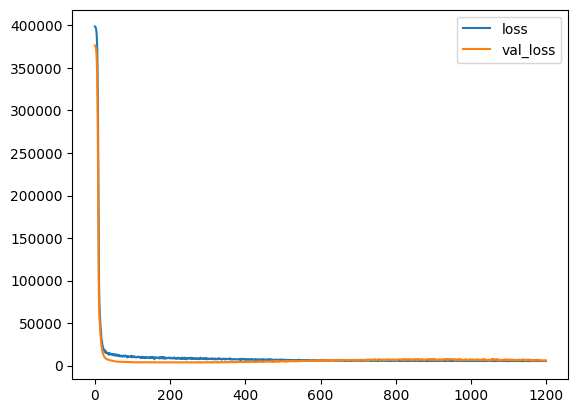

In [11]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Since we used ModelCheckpoint, we have to load the best model version again at this point

In [12]:
# replace the model from last epoch with best epoch from training history
from keras.models import load_model
model = load_model("best_model_regression1_energybill_kt.keras")

In [13]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
4505.677734375

Train data evaluation:
3796.324951171875


In [14]:
# get test predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,Test True Y,Model Predictions
0,473.820453,557.353760
1,658.964880,610.162903
2,590.081794,529.237610
3,718.222564,693.517639
4,711.345373,763.540344
...,...,...
145,630.197137,604.624390
146,425.077564,532.661194
147,418.783248,360.073181
148,382.628898,411.822723


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

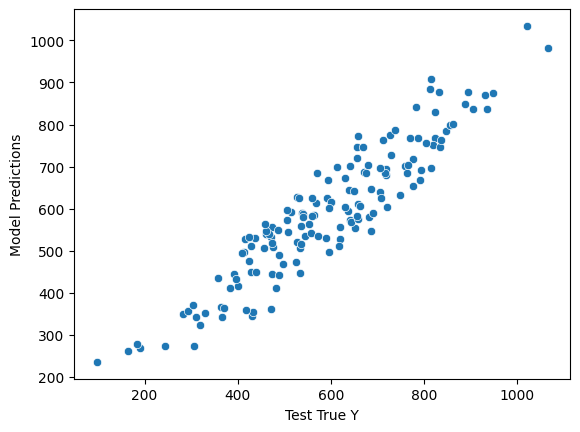

In [15]:
# these values follow a linear diagonal line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

# looks pretty decent!

#### The metrics are way better this time! (Compare to the original version from lecture 1)

In [16]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
58.03 $

MSE
4499.73 $^2

RMSE:
67.08 $

R-squared:
0.86

Explained variance score:
0.86


#### From 109 RMSE  to ~64, quite decent optimization, even though there is still room for improvement

C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_2440\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


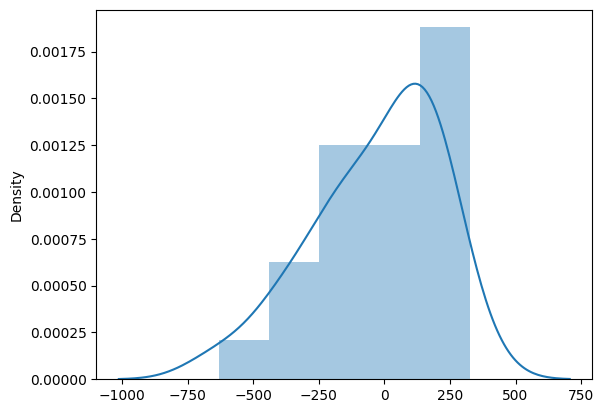

In [ ]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [ ]:
df.columns

Index(['num_rooms', 'num_people', 'housearea', 'is_ac', 'is_tv', 'is_flat',
       'ave_monthly_income', 'num_children', 'is_urban', 'amount_paid'],
      dtype='object')

#### Trying the model in practice with new imaginary house

In [ ]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
    'num_rooms': 7, 
    'num_people': 2, 
    'housearea': 350, 
    'is_ac': 0, 
    'is_tv': 0, 
    'is_flat': 0,
    'ave_monthly_income': 1500, 
    'num_children': 0, 
    'is_urban': 0
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [ ]:
# get the prediction from the model and print out the result
result = model.predict(tester_row)[0]

print()
print(f"Estimated energy bill for this house:")
print(f"$ {round(float(result[0]), 2)}")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

Estimated energy bill for this house:
$ 227.8
----------------
